<h1>Table of Contents<span class="tocSkip"></span></h1>
<div class="toc"><ul class="toc-item"><li><span><a href="#Read-Data" data-toc-modified-id="Read-Data-1"><span class="toc-item-num">1&nbsp;&nbsp;</span>Read Data</a></span><ul class="toc-item"><li><span><a href="#OBS" data-toc-modified-id="OBS-1.1"><span class="toc-item-num">1.1&nbsp;&nbsp;</span>OBS</a></span></li><li><span><a href="#BIOPERIANT12" data-toc-modified-id="BIOPERIANT12-1.2"><span class="toc-item-num">1.2&nbsp;&nbsp;</span>BIOPERIANT12</a></span></li></ul></li><li><span><a href="#Plot-snapshots" data-toc-modified-id="Plot-snapshots-2"><span class="toc-item-num">2&nbsp;&nbsp;</span>Plot snapshots</a></span></li><li><span><a href="#Plot-vertical-profile-and-dFE-climatology" data-toc-modified-id="Plot-vertical-profile-and-dFE-climatology-3"><span class="toc-item-num">3&nbsp;&nbsp;</span>Plot vertical profile and dFE climatology</a></span></li></ul></div>

# Plot Iron profile vs data  

Code: S. Nicholson

In [1]:
import sys
import os
src_path = os.path.abspath(os.path.join(os.getcwd(), '../src'))
sys.path.append(src_path)
import bp12_tools as bp12
import bp12_tools.plot_utils as pu

import pandas as pd
import numpy as np
import xarray as xr

from cartopy import crs as ccrs, feature as cfeature
from cmcrameri import cm
import cmocean.cm as cmo
import matplotlib as mpl
import matplotlib.pyplot as plt
import matplotlib.gridspec as gridspec

%matplotlib inline

import warnings
warnings.filterwarnings("ignore")

---

## Read Data

In [20]:
fe_title = pu.formatting.get_label_mplstr('Fer')
fe_cbar = f"dFe {pu.formatting.get_unit_mplstr(bp12.model_utils.get_varinfo('Fer', 'unit'))}"

### OBS

In [4]:
dfetag = pd.read_csv(f'../data/DFE/tagliabue_fe_database_jun2015_public1.csv',delimiter=';',na_values=-999)

Extract data in the SO and group by interannual months

In [5]:
dfetag_so = dfetag[dfetag.Lat < -30]
dfetag_month = dfetag_so.groupby('month')
dfetag_year = dfetag_so.groupby('year')

Extract for BP12 period and for upper 50m

In [6]:
dfetagz50 = (dfetag_so.depth < 50) & (dfetag_so.year < 2010) & (dfetag_so.year >= 2000)
surf_obs_z50_mean = dfetag_so[dfetagz50].groupby('month').mean().dFe
surf_obs_z50_std = dfetag_so[dfetagz50].groupby('month').std().dFe

Create seasonal cycle clim

In [7]:
surf_obs_z50_mean1 =np.interp(np.arange(1,13,1),surf_obs_z50_mean.index,surf_obs_z50_mean.values)
surf_obs_z50_std1 =np.interp(np.arange(1,13,1),surf_obs_z50_std.index,surf_obs_z50_std.values)

In [8]:
surf_obs_z50_mean1 =np.interp(np.arange(1,13,1),surf_obs_z50_mean.index,surf_obs_z50_mean.values)
surf_obs_z50_mean1[8] = np.nan
surf_obs_z50_mean1[9] = np.nan
surf_obs_z50_std[5] = 0
surf_obs_z50_std1 =np.interp(np.arange(1,13,1),surf_obs_z50_std.index,surf_obs_z50_std.values)
surf_obs_z50_std1[4] = np.nan
surf_obs_z50_std1[8] = np.nan
surf_obs_z50_std1[9] = np.nan

Reorder to start year from July

In [9]:
feclim_obs_mean = np.concatenate([surf_obs_z50_mean1[6:],surf_obs_z50_mean1[:6]])
feclim_obs_std  = np.concatenate([surf_obs_z50_std1[6:], surf_obs_z50_std1[:6]])

### BIOPERIANT12

Snapshots of Iron 5-day means, winter-Aug, summer-Jan

In [10]:
biosnapw = xr.open_dataset(f"../data/DFE/BIOPERIANT12_Fer_surf_y2008m08d18.nc")
biosnaps = xr.open_dataset(f"../data/DFE/BIOPERIANT12_Fer_surf_y2008m01d05.nc")

Get pre-calculated unweighted profile over SO domain

In [11]:
# unweighted profile
fe_profile_mdl = xr.open_dataset(f"../data/DFE/BIOPERIANT12_Fer_profile_clim.nc")

In [12]:
fe_mdl_mean = fe_profile_mdl.Fer_mean
fe_mdl_std  = fe_profile_mdl.Fer_std
fe_mdl_z    = fe_profile_mdl.deptht

Get 0-50m surface-average Fe climatology for BP12 

In [13]:
fe_clim_mdl = xr.open_dataset(f"../data/DFE/BIOPERIANT12_Fer_0to50_clim_monthly.nc")
fe_ann_mdl = fe_clim_mdl.mean('time')

Calculate surf mean for full domain using above

In [14]:
surf_mdl_z50_mean = fe_clim_mdl.Fer.mean(('lat','lon'))
surf_mdl_z50_std  = fe_clim_mdl.Fer.std(('lat','lon'))

In [15]:
feclim_mdl_mean = np.concatenate([surf_mdl_z50_mean[6:],surf_mdl_z50_mean[:6]])
feclim_mdl_std  = np.concatenate([surf_mdl_z50_std[6:], surf_mdl_z50_std[:6]])

## Plot snapshots

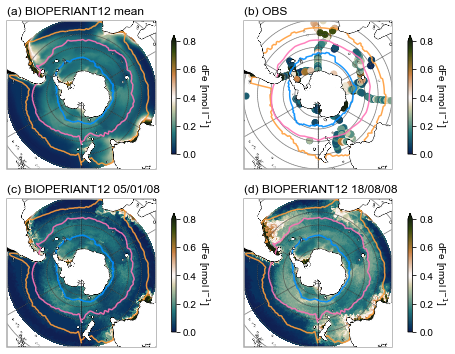

In [22]:
fig = plt.figure(figsize=(12, 6))

######### ---------- MAPS -------------- ###########

ax1 = fig.add_subplot(2, 3, 1, projection = ccrs.Stereographic(central_latitude=-90))
plt.title('(a) BIOPERIANT12 mean',loc='left',fontsize=12)
mesh = ax1.pcolormesh(fe_ann_mdl.lon, fe_ann_mdl.lat, fe_ann_mdl.Fer,    
                     cmap=cmo.tarn_r, vmin=0,vmax=.8,
                     transform=ccrs.PlateCarree(),zorder=0)
cb = plt.colorbar(mesh, shrink=0.8, aspect = 25, pad = 0.08, extend='max')
cb.set_label(fe_cbar, rotation=-90, labelpad=15)
pu.maps.map_decorator(ax1)
pu.maps.add_biomes(ax1, dataset="mdl")


ax2 = fig.add_subplot(2, 3, 2, projection = ccrs.Stereographic(central_latitude=-90))
plt.title('(b) OBS',loc='left',fontsize=12)
pp=ax2.scatter(dfetag_so.long[dfetagz50],dfetag_so.Lat[dfetagz50],c=dfetag_so.dFe[dfetagz50],
               cmap=cmo.tarn_r, vmin=0,vmax=.8,
               transform=ccrs.PlateCarree())
cb = plt.colorbar(pp, shrink=0.8, aspect = 25, pad = 0.08, extend='max')
cb.set_label(fe_cbar, rotation=-90, labelpad=15)
pu.maps.map_decorator(ax2)
pu.maps.add_biomes(ax2, dataset="obs")


ax4 = fig.add_subplot(2, 3, 4, projection = ccrs.Stereographic(central_latitude=-90))
plt.title('(c) BIOPERIANT12 05/01/08',loc='left',fontsize=12)
mesh = ax4.pcolormesh(biosnaps.lon, biosnaps.lat, biosnaps.Fer,  
                     cmap=cmo.tarn_r, vmin=0,vmax=.8,
                     transform=ccrs.PlateCarree(),zorder=0)
cb = plt.colorbar(mesh, shrink=0.8, aspect = 25, pad = 0.08, extend='max')
cb.set_label(fe_cbar, rotation=-90, labelpad=15)
pu.maps.map_decorator(ax4)
pu.maps.add_biomes(ax4, dataset="mdl")

ax5 = fig.add_subplot(2, 3, 5, projection = ccrs.Stereographic(central_latitude=-90))
plt.title('(d) BIOPERIANT12 18/08/08',loc='left',fontsize=12)
mesh = ax5.pcolormesh(biosnapw.lon, biosnapw.lat, biosnapw.Fer,  
                        cmap=cmo.tarn_r, vmin=0,vmax=.8,
                     transform=ccrs.PlateCarree(),zorder=0)
cb = plt.colorbar(mesh, shrink=0.8, aspect = 25, pad = 0.08, extend='max')
cb.set_label(fe_cbar, rotation=-90, labelpad=15)
pu.maps.map_decorator(ax5)
pu.maps.add_biomes(ax5, dataset="mdl")

plt.tight_layout()
plt.savefig(f'../figures/Fig10a_Fe.png', bbox_inches='tight')

## Plot vertical profile and dFE climatology

In [23]:
red, blue = pu.formatting.get_rbg_colors('r'), pu.formatting.get_rbg_colors('b')

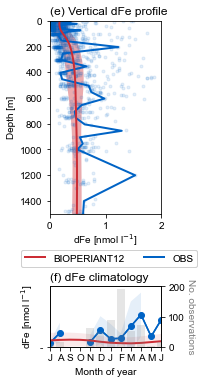

In [31]:
fig = plt.figure(figsize=(2, 6))

gs = gridspec.GridSpec(nrows=3, ncols=2, hspace=1.2)

#--- plot vertical ---
ax4 = fig.add_subplot(gs[:2, :])
# Plot binned observations
ax4.plot(dfetag_so.groupby('depth').mean().dFe,dfetag_so.groupby('depth').mean().index,'.',color=blue,
         alpha=0.1,label='OBS')
custom_bin = np.r_[np.arange(5, 105, 10),np.arange(105, 1000, 50),np.arange(1000, 4000, 200)]
ax4.plot(np.interp(custom_bin ,dfetag_so.groupby('depth').mean().index,dfetag_so.groupby('depth').mean().dFe),
         custom_bin ,lw=2,color=blue,label='OBS mean')
# Plot model mean and std dev
al = [0.05,0.1,0.2,0.3,0.4,0.5,0.6,0.7,0.75,0.8,0.85,0.9,1]
ax4.plot(fe_mdl_mean, fe_mdl_z, lw=2, color=red, label='BIOPERIANT12')
ax4.fill_betweenx(fe_mdl_z, fe_mdl_mean-fe_mdl_std, fe_mdl_mean+fe_mdl_std, 
                  facecolor=red, alpha=0.4,label='BIOPERIANT12 $\sigma$', zorder=2)
ax4.set_xlabel(fe_cbar, labelpad=2)
ax4.set_ylabel('Depth [m]')
ax4.set_ylim(1500,0)
ax4.set_xlim(0,2)
ax4.set_title('(e) Vertical dFe profile', loc='left', fontsize=12)
ax4.set_rasterized(True)
line_mdl = mpl.lines.Line2D([], [], color=red, lw=2, label='BIOPERIANT12')
line_obs = mpl.lines.Line2D([], [], color=blue,lw=2, label='OBS')
leg1 = ax4.legend(handles = [line_mdl, line_obs], ncol=2, fontsize=10, 
          bbox_to_anchor=(-0.3,-0.3), loc="lower left",frameon=True)
ax4.add_artist(leg1)

#--- plot upper 50m clim seas cycle ---
ax3 = fig.add_subplot(gs[2, :])
ax3.plot(np.arange(1,13,1), feclim_obs_mean, blue, '-',label='OBS')
ax3.plot(np.arange(1,13,1), feclim_obs_mean, blue, marker='o')
ax3.fill_between(np.arange(1,13,1) ,feclim_obs_mean+feclim_obs_std, feclim_obs_mean-feclim_obs_std, 
                 facecolor=blue, alpha=0.1,label= 'OBS $\sigma$')
ax3.set_xlabel('Month of year', labelpad=5)
ax3.set_ylabel(fe_cbar)
ax3.plot(np.arange(1,13,1), feclim_mdl_mean, lw=2,color=red,label='BIOPERIANT12')
ax3.fill_between(np.arange(1,13,1), feclim_mdl_mean+feclim_mdl_std, feclim_mdl_mean-feclim_mdl_std, 
                 facecolor=red, alpha=0.1,label= 'BIOPERIANT12 $\sigma$')
ax3.set_title('(f) dFe climatology', loc='left', fontsize=12)
ax3.set_xlim(1,12)

ax31 = ax3.twinx()  
surf_obs_z50_count = dfetag_so[dfetagz50].groupby('month').count().dFe
surf_obs_z50_count1 = np.interp(np.arange(1,13,1),surf_obs_z50_count.index, surf_obs_z50_count.values)
surf_obs_z50_count1[8] = np.nan
surf_obs_z50_count1[9] = np.nan
obs_count = np.concatenate([surf_obs_z50_count1[6:],surf_obs_z50_count1[:6]])


ax31.bar(np.arange(1,13,1), obs_count, color='grey', alpha=.2)
ax31.set_ylabel('No. observations', color='grey', labelpad=10, rotation=-90)
ax31.set_xlim(1,12)
ax31.set_ylim(0,200)
ax3.set_xticks([1,2,3,4,5,6,7,8,9,10,11,12])
ax3.set_xticklabels(['J', 'A', 'S', 'O', 'N', 'D', 'J', 'F', 'M', 'A', 'M', 'J'])
ax3.set_ylim(0,2)
ax3.set_rasterized(True)

plt.tight_layout()
plt.savefig(f'../figures/Fig10b_Fe', bbox_inches='tight')

# Combine images

In [32]:
from PIL import Image

In [33]:
im1 = Image.open(f'../figures/Fig10a_Fe.png')
im2 = Image.open(f'../figures/Fig10b_Fe.png')
im_final  = Image.new('RGB', (im1.width+im2.height, im2.height), (255, 255, 255))
im_final.paste(im1,(0, 0))
im_final.paste(im2, (im1.width, 0))
im_final.show()

In [37]:
im_crop = im_final.crop((0, 0, im_final.width-750, im_final.height))
im_crop.show()
im_crop.save(f'../figures/f10.png', bbox_inches='tight')